In [ ]:
import pandas as pd

fn = "finalmean_reduced_bbob_2_8_0.csv"
df = pd.read_csv(fn)
df = df[df["optimizer_id"].str.startswith("PPO")]

def extract_info(x) -> dict:
    arch = x.split("--")[0].split("-")[1]
    norm = "norm" in x
    reward = x.split("_R")[1].split("-")[0]
    aspace = x.split("_A")[1].split("_S")[0]
    iset = x.split("_I")[1]
    refperf = x.split("_R")[1].split("-")[1].split("_")[0]
    return {
        "architecture": arch,
        "normalize_obs": str(norm),
        "reward": reward,
        "action_space": aspace,
        "instance_set": iset,
        "reference_performance": refperf
    }
df["info"] = df["optimizer_id"].map(extract_info)
expanded = df["info"].apply(pd.Series)
cols = list(expanded.columns)
df = df.drop(columns="info").join(expanded)
del df["optimizer_id"]

df


,log_regret_plot,architecture,normalize_obs,reward,action_space,instance_set,reference_performance
2,-2.319999,RNN,True,episode_finished_scaled,WEI-skip,bbob2d_3seeds,DefaultAction
3,-2.927500,RNN,False,episode_finished_scaled,WEI-skip,bbob2d_3seeds,DefaultAction
4,-3.388808,RNN,True,episode_finished_scaled,WEI-cont,bbob2d_fid8_3seeds,SAWEI
5,-3.543149,MLP,True,symlogregret,WEI-cont,bbob2d_fid8_3seeds,SAWEI
6,-3.672772,RNN,True,episode_finished_scaled,WEI-skip,bbob2d_fid8_3seeds,DefaultAction
...,...,...,...,...,...,...,...
62,-6.511407,RNN,False,symlogregret,WEI-cont,bbob2d_3seeds,SAWEI
63,-6.550146,MLP,True,episode_finished_scaled,WEI-cont,bbob2d_3seeds,SAWEI
64,-6.691643,RNN,True,symlogregret,WEI-skip,bbob2d_fid8_3seeds,SAWEI
65,-6.797727,RNN,False,symlogregret,WEI-skip,bbob2d_fid8_3seeds,DefaultAction


Configuration space object:
  Hyperparameters:
    action_space, Type: Categorical, Choices: {WEI-skip, WEI-cont}, Default: WEI-skip
    architecture, Type: Categorical, Choices: {RNN, MLP}, Default: RNN
    instance_set, Type: Categorical, Choices: {bbob2d_3seeds, bbob2d_fid8_3seeds}, Default: bbob2d_3seeds
    normalize_obs, Type: Categorical, Choices: {True, False}, Default: True
    reference_performance, Type: Categorical, Choices: {DefaultAction, SAWEI}, Default: DefaultAction
    reward, Type: Categorical, Choices: {episode_finished_scaled, symlogregret}, Default: episode_finished_scaled



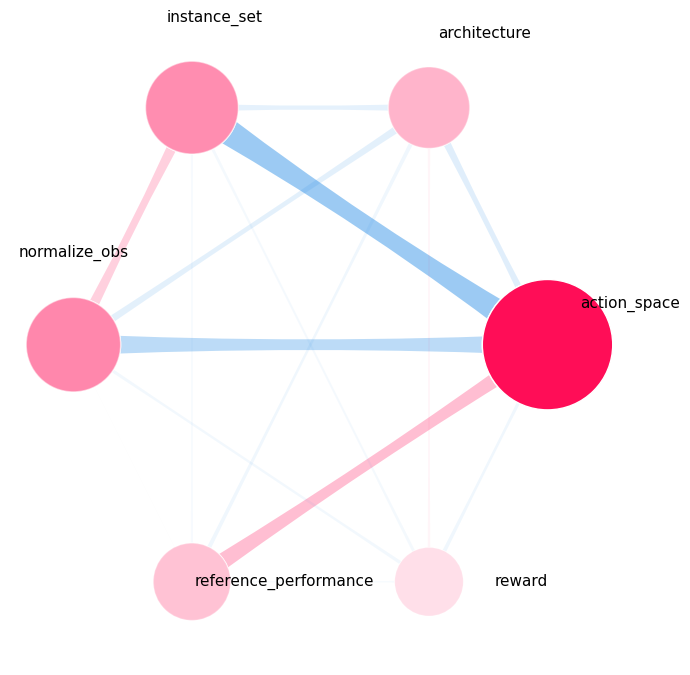

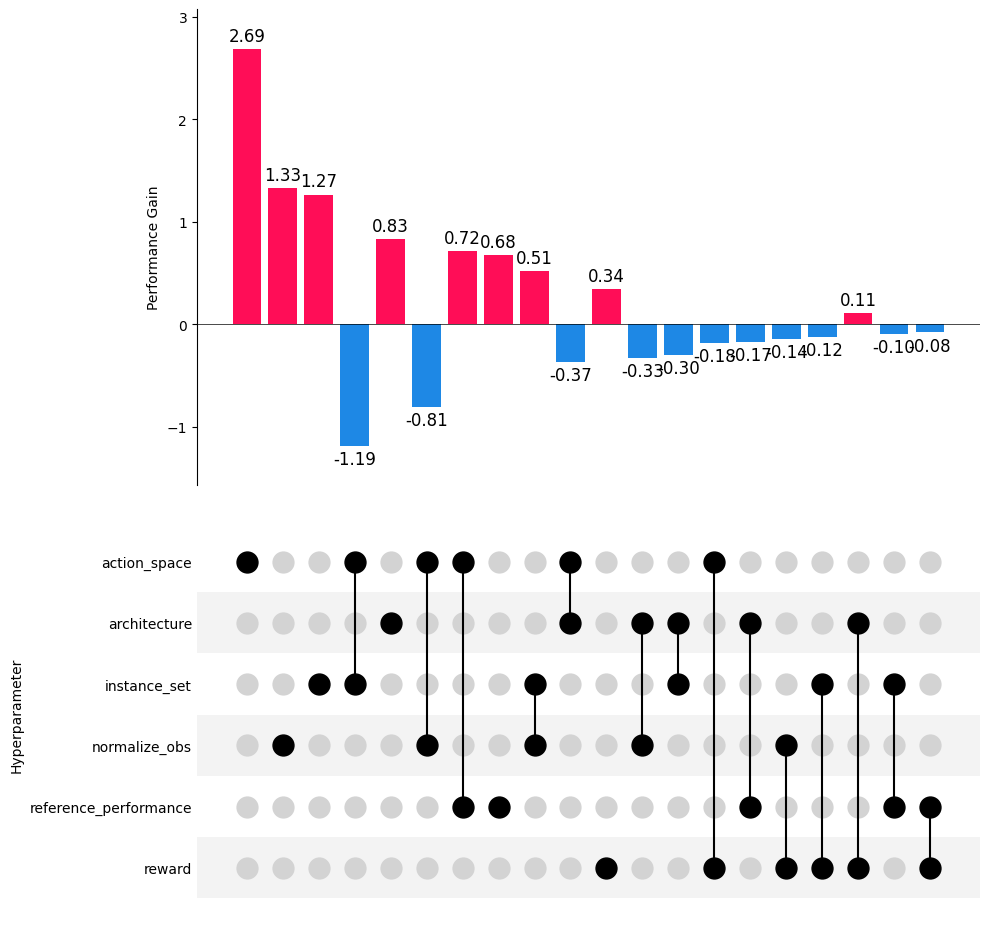

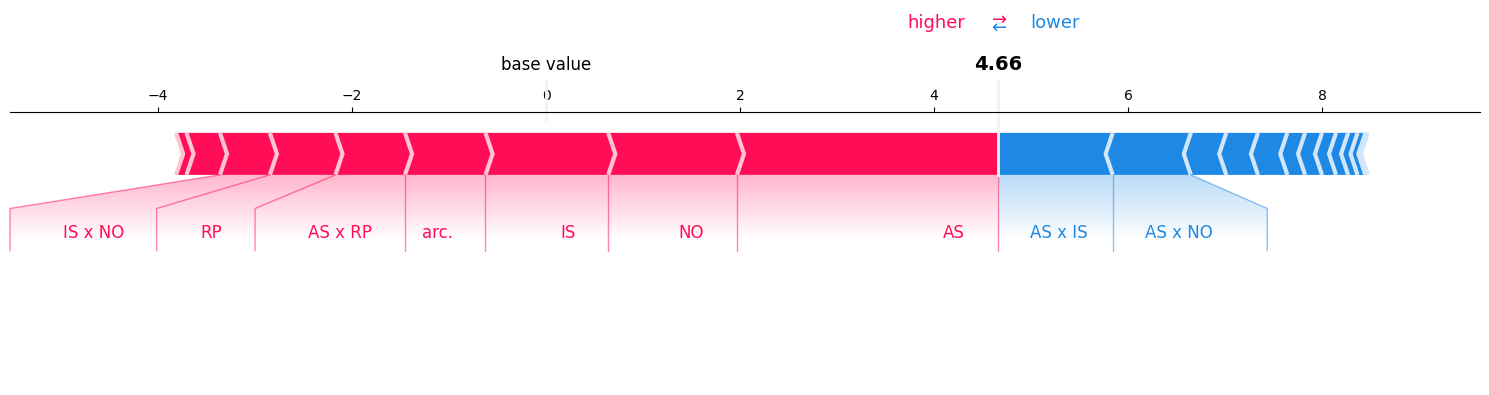

In [51]:
from ConfigSpace import ConfigurationSpace, Categorical, Configuration
import numpy as np
from hypershap.hypershap import HyperSHAP
from hypershap.task import ExplanationTask

cs = ConfigurationSpace()
hps = []
for c in cols:
    unique_vals = list(df[c].unique())
    hp = Categorical(name=c, items=unique_vals)
    hps.append(hp)
cs.add(hps)
print(cs)

df_i = df.set_index(cols)
df_i.to_csv("df_i.csv")

def eval_fun(config: Configuration) -> float:
    cfg_dict = dict(config)
    index = tuple(str(cfg_dict[n]) for n in df_i.index.names)
    return df_i.loc[index, "log_regret_plot"]


explanation_task = ExplanationTask.from_function(config_space=cs, function=eval_fun)
hypershap = HyperSHAP(explanation_task=explanation_task)
# iv = hypershap.ablation(config_of_interest=config_of_interest, baseline_config=baseline_config)
# print(iv)

baselince_cfg = ["RNN","False","episode_finished_scaled","WEI-cont","bbob2d_3seeds","SAWEI"]
baseline_config = Configuration(configuration_space=cs, values=dict(zip(df_i.index.names, baselince_cfg)))

iv = hypershap.tunability(baseline_config=baseline_config)
# print(iv)
hypershap.plot_si_graph()
hypershap.plot_upset()
hypershap.plot_force()